# MNIST
framing the problem : we want to classify images of handwritten images 
# Download the Data 

In [15]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

these keys of mnist DESCR key to describe the dataset 
data key containing an array with one row per instance and one column per feature 
target key containing an array with the labels 

In [16]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [17]:
y.shape

(70000,)

There are 70k images and each image have 784 features because each image have 28*28 pixels which is 784 , each pixel represents one pixel's intensity from (0: white) to (255: black)

In [18]:
28 * 28

784

let's display an instance to see how it looks like 

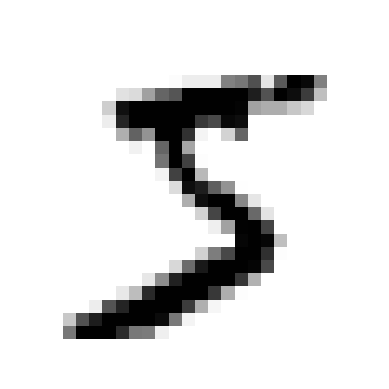

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

this is supposed to be 5 let's check

In [20]:
y[0]

'5'

the value is a string we need to convert labels to integer

In [21]:
import numpy as np

y = y.astype(np.uint8)

## Split the data train/test
it's already defined in the MNIST dataset 

In [22]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier
we can call it "5-detector" because this binary classifier capable of distinguishing between just two classes,5 and not 5

In [23]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

let's train a classifier "SGD" this one handle large data set an treat each instance independently

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [25]:
# we try it on the digit we displayed earlier 
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

accuracy above 95%, it's near to prefect but let's see why 

In [30]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [31]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

when we make a non 5 classifier we see that only 10% of our data is 5 

## Confusion Matrix
a better way to evaluate the performance of a classifier because here we'll have for example the number of instances of class A classified as class B, and to do that we need to have a set of predictions so we can compare it to the actual targets

In [32]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict work as same as cross_val_score but instead of returning scores it returns predictions 

In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

each row of the confusion matrix represents an actual class, while each column represents a predicted class.
-- the first row considers non 5 images here we can see that 53892 are classified as non 5s (True negative), and 1,522 were wrongly classified as 5s (fasle positive)
-- the second row considers 5 images we can see that 1891 were wrongly classified as non 5 images (false negative) and 3530 are classified as 5s (True Positive)

a perfect classifier would have only True Negatives & True Positives means that the matrix would have non zero values only on its main diagonal 

In [34]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection to give an example of how a perfect classifier would look like 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives a lot of informations but there are some intreseting metrics that we can look into, 
an interesting one is the accuracy of the positive predictions or we can call it "precision" = TP / TP + FP , the precision is used along with another metric named "recall" also called true positive rate(TPR) the ratio of positive instances that are detected by the classifier , recall = TP / TP + FN 

## Precision and Recall
sklearn provides functions to compute classifier metrics 

In [37]:
from sklearn.metrics import precision_score, recall_score

print("precision",precision_score(y_train_5, y_train_pred))

print("recall",recall_score(y_train_5, y_train_pred))

precision 0.8370879772350012
recall 0.6511713705958311


and this a prove that accuracy it's not a metric that we can count on it everytime, here we can see that the classifier etects only 65.1% of the 5s, when it claims an image represents a 5, it is correct only 83% of the time .
it is convinient to combine precision and recall into a single metric which called the F1 score & we use it ofently to compare two classifiers (F1 score is the harmonic of precision and recall) F1 = 2 / 1/precision  + 1/recall 

In [38]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Trade-off
means that increasing precision reduces recall, and vice versa. 

In [39]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

Decision score is a value that represents how confident a model is in its prediction,
For binary classification, the decision score is usually a single number. The sign (positive or negative) indicates which class the model predicts, and the magnitude represents the confidence.
A high positive score strongly indicates one class.
A high negative score strongly indicates the opposite class

In [43]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [44]:
y_some_digit_pred

array([ True])

SGD uses a class equal to 0 let's try to raise the threshold 

In [46]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

this proves that raising the threshold decrease the recall 
to decide which threshold to use we get the the scores of all instances using cross_val_predict and we specify that we want to return the decision score and we plot the curve of recall and precision to decide 

In [47]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [48]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

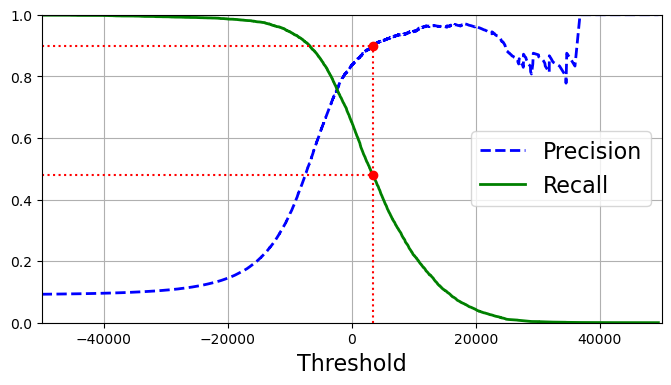

In [52]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

we can see that precision curve is bumpier the reason is that precision may sometimes go down when you raise the threshold ,
a good way to select a good precision/ recall tradeoff is to plot precision against recall directly 

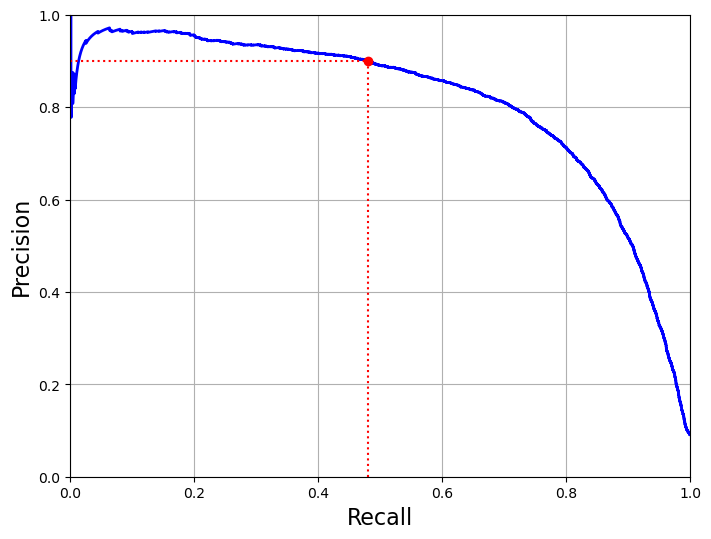

In [54]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

we can see that precision really starts to fall around 90% recall . we may want to choose the precision just before the drop.

let's say we want to have a precision of 90% we get the value of the threshold using argmax 

In [60]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [61]:
threshold_90_precision

3370.0194991439557

In [62]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [63]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [64]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve
it's another common tool used with binary classifiers and it's similar to precision/ recall curve 
instead of plotting precision versus recall, the ROC curve plots the true positive rate (recall) against the false positive rate 

In [65]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

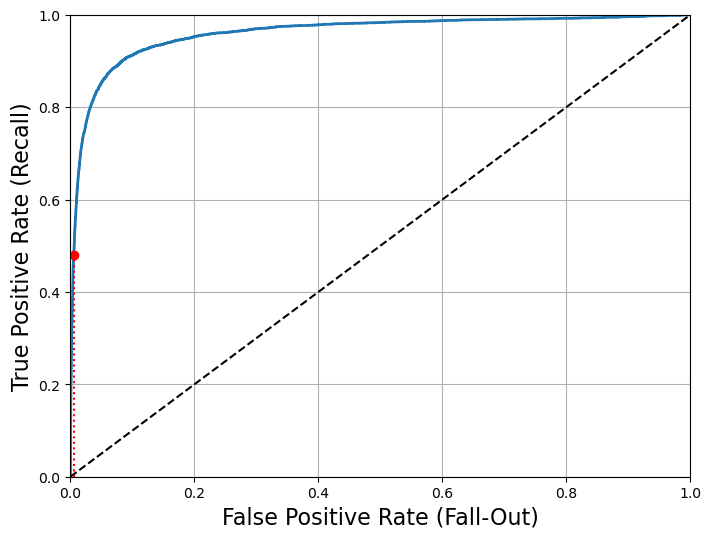

In [66]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of purely random classifier stays as far away from that line as possible (toward the top-left corner), one way to compare classifiers is to measure the area under the curve (AUC) a prefect classifier will have a ROC AUC equal to 1 ,whereas a purely random classifier will have a ROC AUC equal to 0.5 

In [67]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

let's train a randomforest classifier and compare it to sgd using ROC curve 

In [68]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [69]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

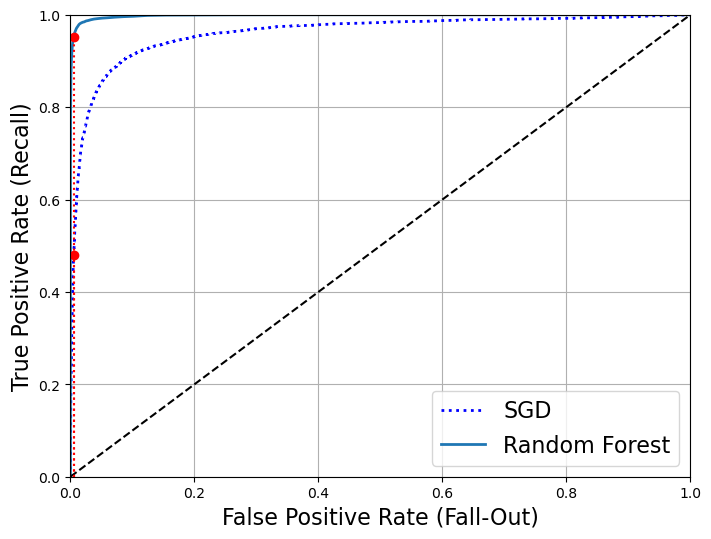

In [70]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [74]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

In [75]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

This code trains the SVC on the training set using the original target
classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes
(y_train_5). Then it makes a prediction (a correct one in this case). Under the hood,
Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their
decision scores for the image, and selected the class that won the most duels

In [81]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [82]:
np.argmax(some_digit_scores)

5

In [83]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [84]:
svm_clf.classes_[5]

5

In [85]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [86]:
len(ovr_clf.estimators_)

10

In [87]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [88]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [89]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [91]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [92]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

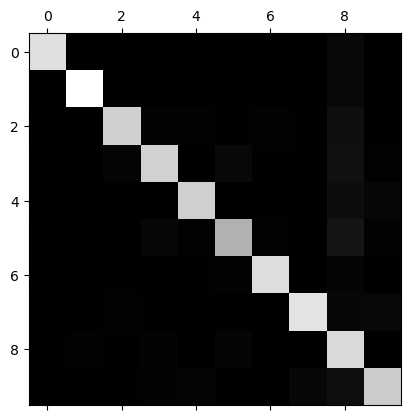

In [94]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [95]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

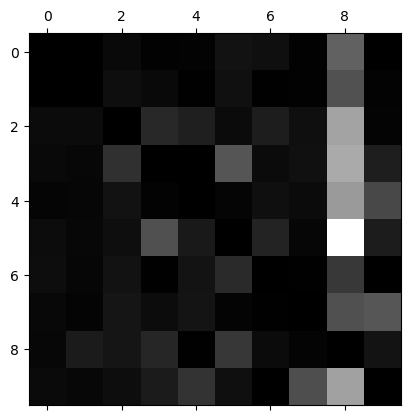

In [97]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification

In [100]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [101]:
knn_clf.predict([some_digit])

C:\Users\walid\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

In [102]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

C:\Users\walid\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\walid\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.976410265560605

# Multioutput Classification

## Dummy (ie. random) classifier

In [105]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

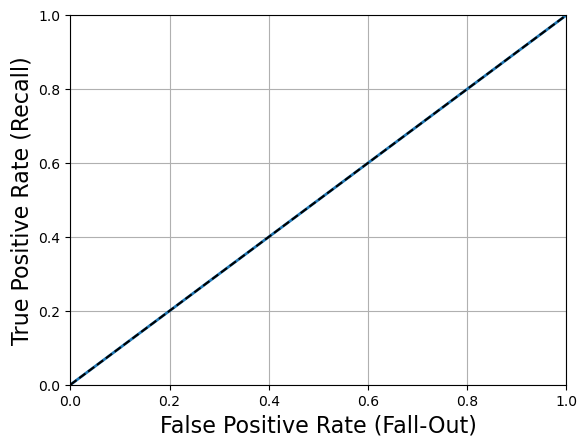

In [106]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [107]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [108]:
y_knn_pred = knn_clf.predict(X_test)

In [109]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

In [111]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [112]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [113]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [114]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [115]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])